In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Warmup [20pt]

In this question, we will train 2 different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

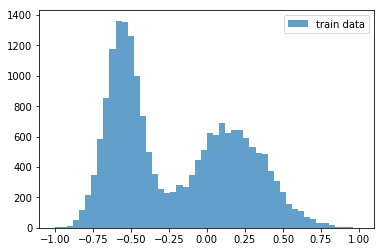

In [2]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """


### Solution

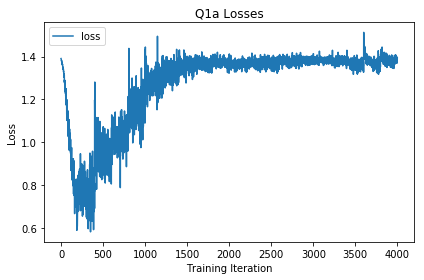

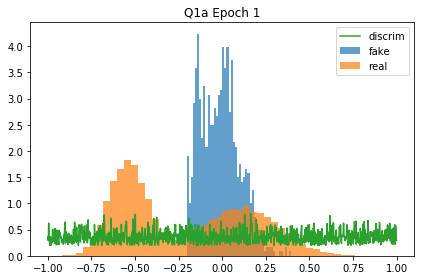

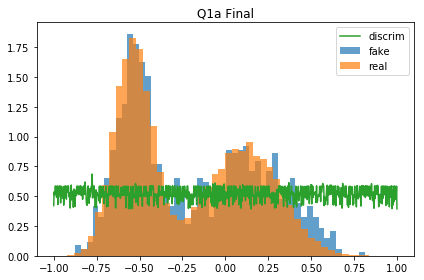

In [96]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
""" 
train discriminator with batch of real + same length generated, keep gen at eval. Once done over a set of 
batches(full dataset in this case), generated batch length points and train generator. Repeat and look at 
sample histograms to stop training.
"""

def classify(G, D,G_optimizer, D_optimizer, loader, latent=1):
    G.eval()
    D.train()
    D_loss = []
    G_loss = []
    bs = 0
    for data in loader:
        #sample a point from normal distribution
        z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
        out = D(data.float().cuda()).squeeze()
        #original gan loss
        loss_ =  - out.log().mean() - (1 - D(G(z.float().cuda()))).squeeze().log().mean()
        D_optimizer.zero_grad()
        loss_.backward(retain_graph=True)
        D_optimizer.step()
        D_loss.append(loss_.item())
    D.eval()
    G.train()
    z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
    G_optimizer.zero_grad()
    out = D(G(z.float().cuda()))
    _loss =  torch.log(1-out).mean()
    _loss.backward()
    G_optimizer.step()
    G_loss.append(_loss.item())
    return G_loss, D_loss
    
#doesn't give good samples with sigmoid, use tanh.
class Generator(nn.Module):
    def __init__(self, latent=1, hidden=128):
        super().__init__()
        self.linear1 = nn.Linear(latent, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, hidden)
        self.linear4 = nn.Linear(hidden, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return F.tanh(self.linear4(x))
    
class Disciminator(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.linear1 = nn.Linear(1, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, hidden)
        self.linear4 = nn.Linear(hidden, 1)
        self.relu = nn.ReLU(0.2)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return F.sigmoid(self.linear4(x))


def q1_a(train_data):
    batch_size = 100
    no_samples = 1000
    latent=1
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    G = Generator().cuda()
    D = Disciminator().cuda()
    #beta specified as in wgan
    G_optimizer = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0, 0.9))
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0, 0.9))
    loss1, loss2 = [], []
    for i in tqdm(range(20)):
        g_loss, d_loss = classify(G, D, G_optimizer, D_optimizer, train_loader)
        if i == 0:
            G.eval()
            D.eval()
            samples1 = G(z.float().cuda())
            dis1 = D(samples1).squeeze()
        loss1.append(g_loss)
        loss2.extend(d_loss)
    G.eval()
    D.eval()
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    samplesEnd = G(z.float().cuda())
    disEnd = D(samplesEnd.cuda()).squeeze()
    return loss2, samples1.detach().cpu().numpy(), np.linspace(-1, 1, 1000), dis1.detach().cpu().numpy(), samplesEnd.detach().cpu().numpy(), np.linspace(-1, 1, 1000), disEnd.detach().cpu().numpy()
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate losses:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z))$$
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]

  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
      at each location in the previous array at the end of training
  """

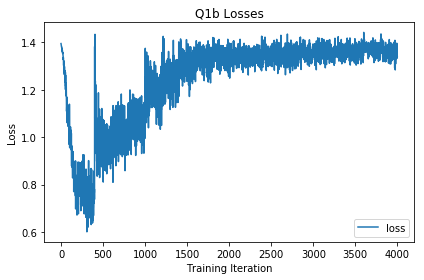

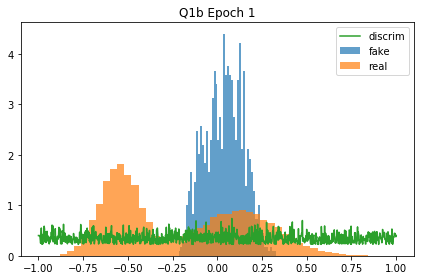

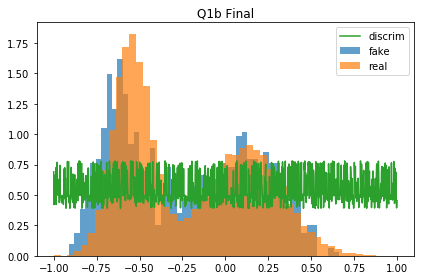

In [97]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
#change generator loss from - torch.log(1-out).mean() to - torch.log(out).mean(), rest same.
def classify(G, D,G_optimizer, D_optimizer, loader, latent=1):
    G.eval()
    D.train()
    D_loss = []
    G_loss = []
    bs = 0
    for data in loader:
        z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
        out = D(data.float().cuda()).squeeze()
        loss_ =  - out.log().mean() - (1 - D(G(z.float().cuda()))).squeeze().log().mean()
        D_optimizer.zero_grad()
        loss_.backward(retain_graph=True)
        D_optimizer.step()
        D_loss.append(loss_.item())
    D.eval()
    G.train()
    z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
    G_optimizer.zero_grad()
    out = D(G(z.float().cuda()))
    _loss =  - torch.log(out).mean()
    _loss.backward()
    G_optimizer.step()
    G_loss.append(_loss.item())
    return G_loss, D_loss
    
    
class Generator(nn.Module):
    def __init__(self, latent=1, hidden=128):
        super().__init__()
        self.linear1 = nn.Linear(latent, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, hidden)
        self.linear4 = nn.Linear(hidden, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return F.tanh(self.linear4(x))
    
class Disciminator(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.linear1 = nn.Linear(1, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, hidden)
        self.linear4 = nn.Linear(hidden, 1)
        self.relu = nn.ReLU(0.2)
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return F.sigmoid(self.linear4(x))


def q1_b(train_data):
    batch_size = 100
    no_samples = 1000
    latent=1
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    G = Generator().cuda()
    D = Disciminator().cuda()
    G_optimizer = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0, 0.9))
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0, 0.9))
    loss1, loss2 = [], []
    for i in tqdm(range(20)):
        g_loss, d_loss = classify(G, D, G_optimizer, D_optimizer, train_loader)
        if i == 0:
            G.eval()
            D.eval()
            samples1 = G(z.float().cuda())
            dis1 = D(samples1).squeeze()
        loss1.append(g_loss)
        loss2.extend(d_loss)
    G.eval()
    D.eval()
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    samplesEnd = G(z.float().cuda())
    disEnd = D(samplesEnd.cuda()).squeeze()
    return loss2, samples1.detach().cpu().numpy(), np.linspace(-1, 1, 1000), dis1.detach().cpu().numpy(), samplesEnd.detach().cpu().numpy(), np.linspace(-1, 1, 1000), disEnd.detach().cpu().numpy()
q1_save_results('b', q1_a)

 ### Results

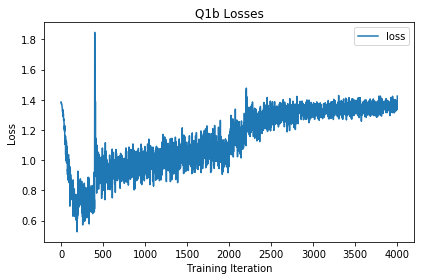

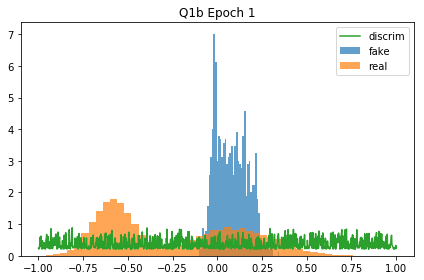

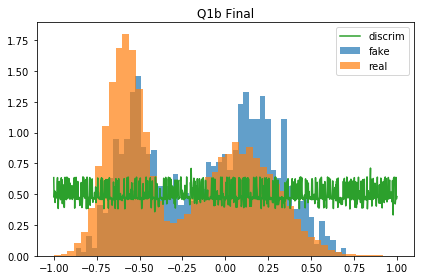

In [98]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

In [2]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output

class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.d2s = DepthToSpace(block_size=2)
        self.conv = Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
    
    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        x = self.d2s(x)
        return self.conv(x)
    

class Downsample_Conv2d(nn.Module):
    def __init__(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.s2d = SpaceToDepth(2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding, bias=bias)
    
    def forward(self, x):
        x = self.s2d(x)
        x = torch.sum(x.chunk(4, dim=1)) / 4.0
        return conv(x)

In [103]:
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init()
        self.bn1 = nn.BatchNorm2d(in_dim)
        self.bn2 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.residual = Upsample_Conv2D(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut = Upsample_Conv2D(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        xd = x
        x = self.relu(self.bn1(x))
        x = x.relu(x.bn2(x.conv(x)))
        return self.residual(xd) + self.shortcut(x)

class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)
        self.residual = Downsample_Conv2D(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut = Downsample_Conv2D(in_dim, n_filters, kernel_size=(1, 1), padding=0)
    
    def forward(self, x):
        xd = x
        x = x.relu(x.conv(x))
        return self.residual(xd) + self.shortcut(x)
    
class Generator(nn.Module):
    def __init__(self, n_samples, n_filters):
        super().__init__()
        self.n_samples = n_samples
        self.n_filters = n_filters
        self.fc1 = nn.Linear(128, 4*4*256)
        self.rbu1 = ResnetBlockUp(in_dim=256, n_filters=n_filters),
        self.rbu2 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.rbu3 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.bn1 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        z = torch.normal(torch.ones(self.n_samples, 128), torch.ones(self.n_samples, 128))
        x = self.fc1(z)
        #reshape
        x = self.rbu1(x)
        x = self.rbu2(x)
        x = self.rbu3(x)
        x = self.relu(self.bn1(x))
        return self.tanh(self.conv(x))
    
class Discriminator(nn.Module):
    def __init__(self, n_samples, n_filters):
        super().__init__()
        self.n_samples = n_samples
        self.n_filters = n_filters
        self.fc1 = nn.Linear(128, 4*4*256)
        self.rbd1 = ResnetBlockDown(in_dim=256, n_filters=n_filters),
        self.rbd2 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
        self.rbd3 = ResnetBlockDown(in_dim=n_filters, n_filters=n_filters)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        z = torch.normal(torch.ones(self.n_samples, 128), torch.ones(self.n_samples, 128))
        x = self.fc1(z)
        #reshape
        x = self.rbd1(x)
        x = self.rbd2(x)
        x = self.relu(self.rbd3(x))
        return self.tanh(self.conv(x))

In [3]:
def classify(G, D,G_optimizer, D_optimizer, loader, latent=1):
    #modify for wgan loss(generate image x, find xb and send xb and x to discriminator and add reg, rest same)
    G.eval()
    D.train()
    D_loss = []
    G_loss = []
    bs = 0
    for data in loader:
        z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
        out = D(data.float().cuda()).squeeze()
        loss_ =  - out.log().mean() - (1 - D(G(z.float().cuda()))).squeeze().log().mean()
        D_optimizer.zero_grad()
        loss_.backward(retain_graph=True)
        D_optimizer.step()
        D_loss.append(loss_.item())
    D.eval()
    G.train()
    z = torch.normal(torch.zeros(data.shape[0], latent).cuda(), torch.ones(data.shape[0], latent).cuda())
    G_optimizer.zero_grad()
    out = D(G(z.float().cuda()))
    _loss =  - torch.log(out).mean()
    _loss.backward()
    G_optimizer.step()
    G_loss.append(_loss.item())
    return G_loss, D_loss
    

def q2(train_data):
    #verify model and train
    batch_size = 100
    no_samples = 1000
    latent=1
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    G = Generator().cuda()
    D = Disciminator().cuda()
    G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0, 0.9))
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0, 0.9))
    loss1, loss2 = [], []
    for i in tqdm(range(20)):
        g_loss, d_loss = classify(G, D, G_optimizer, D_optimizer, train_loader)
        if i == 0:
            G.eval()
            D.eval()
            samples1 = G(z.float().cuda())
            dis1 = D(samples1).squeeze()
        loss1.append(g_loss)
        loss2.extend(d_loss)
    G.eval()
    D.eval()
    z = torch.normal(torch.zeros(no_samples, latent).cuda(), torch.ones(no_samples, latent).cuda())
    samplesEnd = G(z.float().cuda())
    disEnd = D(samplesEnd.cuda()).squeeze()
    return loss2, samples1.detach().cpu().numpy(), np.linspace(-1, 1, 1000), dis1.detach().cpu().numpy(), samplesEnd.detach().cpu().numpy(), np.linspace(-1, 1, 1000), disEnd.detach().cpu().numpy()
q2_save_results(q2)    
#pytorch requires updated drives after updating torchvision, find and install/use colab.

Files already downloaded and verified


AssertionError: 
The NVIDIA driver on your system is too old (found version 9010).
Please update your GPU driver by downloading and installing a new
version from the URL: http://www.nvidia.com/Download/index.aspx
Alternatively, go to: https://pytorch.org to install
a PyTorch version that has been compiled with your version
of the CUDA driver.